## Imports

In [1]:
import pandas as pd
import nltk
import re
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [2]:
# installing punctuation of English for preprocessing purposes
nltk.download('punkt')
# installing stop words of English for preprocessing purposes
nltk.download('stopwords')
# installing English words
nltk.download('words')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\moham\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\moham\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\moham\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

## Loading External Data

First of all, I downloaded the new data for training my model from this [Kaggle Link](https://www.kaggle.com/datasets/jiashenliu/515k-hotel-reviews-data-in-europe), then I unzipped, renamed the file to be _`euro-hotels-reviews-515k.csv`_ and stored it into that path _`/Storage/Data/External/`_

> __Make sure that you have dowloaded the new external data before running the next cells!__
> 
> Data is too big to be tracked or pushed to GitHub, so We'll add it to `.gitignore`

In [3]:
data = pd.read_csv("../Storage/Data/External/euro-hotels-reviews-515k.csv")
data['Review'] = data['Negative_Review']+ data['Positive_Review']

# create the label
data["Sentiment"] = data["Reviewer_Score"].apply(lambda x: 'Negative' if x < 5 else 'Positive')
# select only relevant columns
data = data[["Review", "Sentiment"]]
data.head(10)

,Review,Sentiment
0,I am so angry that i made this post available...,Negative
1,No Negative No real complaints the hotel was g...,Positive
2,Rooms are nice but for elderly a bit difficul...,Positive
3,My room was dirty and I was afraid to walk ba...,Negative
4,You When I booked with your company on line y...,Positive
5,Backyard of the hotel is total mess shouldn t...,Positive
6,Cleaner did not change our sheet and duvet ev...,Negative
7,Apart from the price for the brekfast Everyth...,Positive
8,Even though the pictures show very clean room...,Positive
9,The aircondition makes so much noise and its ...,Positive


In [4]:
# check labels counts
data['Sentiment'].value_counts()

Positive    493457
Negative     22281
Name: Sentiment, dtype: int64

#### Just take random stratified samples of 10000 records for each sentiment

In [5]:
# just take random stratified sample of 10000 
hotels = data.groupby('Sentiment', group_keys=False).apply(lambda x: x.sample(20000))
hotels['Sentiment'].value_counts(normalize=True)

Negative    0.5
Positive    0.5
Name: Sentiment, dtype: float64

In [6]:
# double check after sampling
hotels.sample(10, random_state=42)

,Review,Sentiment
257560,Rug was rather stained Service Big room Grea...,Positive
478390,The heating system is very noisy and you can ...,Negative
2038,Although it wasn t an issue for me as it wasn...,Positive
105108,VERY OLD UPHOLSTRY CARPETS ARE STINKING AND D...,Negative
173956,Found the breakfast staff quite unfriendly an...,Positive
58700,No Negative The bed was very comfortable and t...,Positive
149694,They actually stole money from us from a mist...,Negative
181657,No Negative Rooms location staff and everythin...,Positive
17360,They charged me several times by accident Th...,Negative
493788,Narrow parking space in front of the hotel wh...,Positive


## Data Preprocessing

In [7]:
def preprocess_text(df):
    # all chars to lower case
    df['cleaned'] = df['Review'].apply(lambda review: review.lower())
    # remove special chars
    df['cleaned'] = df['cleaned'].map(lambda review: re.sub(r'\W+', ' ', review))
    # remove non-English words
    words = set(nltk.corpus.words.words())
    df['cleaned'] = df['cleaned'].apply(lambda review: " ".join(w for w in nltk.wordpunct_tokenize(review) \
                                                                      if w in words or not w.isalpha()))
    # remove English stopwords
    stopwords = nltk.corpus.stopwords.words('english')
    df['cleaned'] = df['cleaned'].apply(lambda review: " ".join(w for w in nltk.wordpunct_tokenize(review) \
                                                                      if w not in stopwords))
    # lemmatize tokens (words)
    lemmatizer = WordNetLemmatizer()
    df['cleaned'] = df['cleaned'].apply(lambda review: " ".join(lemmatizer.lemmatize(w) for w in nltk.wordpunct_tokenize(review)))

    return df['cleaned']

    

In [8]:
X = preprocess_text(hotels.drop(['Sentiment'], axis=1))
y = hotels['Sentiment']

hotels['Review'].iloc[0], X.iloc[0]

(' We never received the daily paper delivery we requested for our four night stay Closet is very small  Friendly and very welcoming staff Room 439 Street view Quiet room Very comfortable bed with reading lights Excellent linens Walk in shower with large rain shower head and a separate flexible shower hosepipe Excellent toiletries Excellent hair dryer Two drawer night stand Large flat screen TV Safe is large enough for a small laptop Empty mini bar refrigerator for your use Two bottles of complimentary water supplied each day Power Point at the desk has 2 USB ports 2 English ports 1 EU port 1 North American port and an RJ45 port Reading chair and lamp The Gloucester tube station is directly across the road from the lobby The Natural History Science and V A Museums are about a 10 minute walk from the hotel ',
 'never received daily paper delivery four night stay closet small friendly welcoming staff room 439 street view quiet room comfortable bed reading excellent walk shower large rain

In [9]:
# split data into train & test regarding sentiment distribution
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((32000,), (8000,), (32000,), (8000,))

#### Saving Preprocessed Data 
for model retraining, testing and evaluation purposes

In [20]:
X_train.to_csv('../Storage/Data/External/X_train.csv')
y_train.to_csv('../Storage/Data/External/y_train.csv')
X_test.to_csv('../Storage/Data/External/X_test.csv')
y_test.to_csv('../Storage/Data/External/y_test.csv')

## Feature Engineering

In [10]:
# Create a pipeline to transform data then train the model
model = Pipeline(steps=[
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 3))), 
    ('predictor', MultinomialNB())
])

## Model Training

With this pipeline, we can apply the model to the training data, and predict labels for the test data:

In [11]:
model.fit(X_train, y_train)
print("Training Score: ", model.score(X_train, y_train))

Training Score:  0.952


In [12]:
y_preds_proba = model.predict_proba(X_test)
y_preds = model.predict(X_test)

print("Testing Score: ", model.score(X_test, y_test))
pd.DataFrame(y_preds).value_counts()

Testing Score:  0.844875


Negative    4423
Positive    3577
dtype: int64

Now that we have predicted the labels for the test data, we can evaluate them to learn about the performance of the estimator.
For example, here is the confusion matrix between the true and predicted labels for the test data:

## Model Evaluation

Text(83.40000000000006, 0.5, 'Predicted Label')

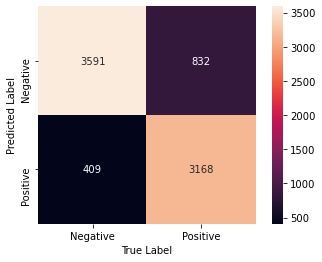

In [13]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


unique_labels = np.unique(y)
mat = confusion_matrix(y_test, y_preds)

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('True Label')
plt.ylabel('Predicted Label')

In [14]:
# Classification Report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

    Negative       0.81      0.90      0.85      4000
    Positive       0.89      0.79      0.84      4000

    accuracy                           0.84      8000
   macro avg       0.85      0.84      0.84      8000
weighted avg       0.85      0.84      0.84      8000



In [15]:
# Save model pipeline, for easier inference
import joblib

joblib.dump(model, '../Storage/Models/MultinomialNB.pkl')

['../Storage/Model/MultinomialNB.pkl']

## Model Running

In [16]:
def predict_sentiment(sentences, model_name='MultinomialNB'):
    if(isinstance(sentences, str)):
        sentences = [sentences]
    try:
        model = joblib.load(f'../Storage/Models/{model_name}.pkl')
        preds = model.predict(sentences)
        preds_proba = model.predict_proba(sentences)
        lens = len(sentences)
        results = []
        for i in range(lens):
            results.append({
                'Sentiment': preds[i], 
                'Positive_prob': preds_proba[i][1], 
                'Negative_prob': preds_proba[i][0]
            })
        return results[0] if lens == 1 else results
    except Exception as e:
        print("ERROR:", e)

In [17]:
# predict single review
predict_sentiment("It's so boring to stay there however the food is great!")

{'Sentiment': 'Positive',
 'Positive_prob': 0.585689724651715,
 'Negative_prob': 0.4143102753482841}

In [18]:
# predict bulk reviews
predict_sentiment([
    "Good service quality but it's noisy a bit!", 
    "It's so dirty to stay there, and the food is very bad!"
])

[{'Sentiment': 'Positive',
  'Positive_prob': 0.6105462104183004,
  'Negative_prob': 0.38945378958170096},
 {'Sentiment': 'Negative',
  'Positive_prob': 0.20874387605765968,
  'Negative_prob': 0.7912561239423418}]